In [68]:
import numpy as np
import torch as th
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image

def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
        # seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    elif segment_part == 'faceseg_ears':
        seg_m = (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_nose':
        seg_m = nose
    elif segment_part == 'faceseg_mouth':
        seg_m = (mouth | u_lip | l_lip)
    elif segment_part == 'faceseg_neck':
        seg_m = neck
    elif segment_part == 'faceseg_eyes&ears&nose&mouth':
        seg_m = (l_eye | r_eye | l_ear | r_ear | ear_r | nose | mouth | u_lip | l_lip)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

(256, 256, 3) (256, 256, 3)
0 17


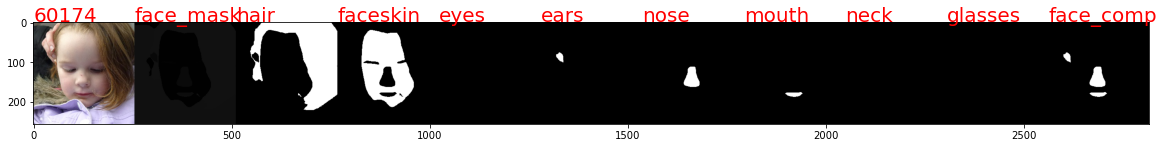

(256, 256, 3) (256, 256, 3)
0 17


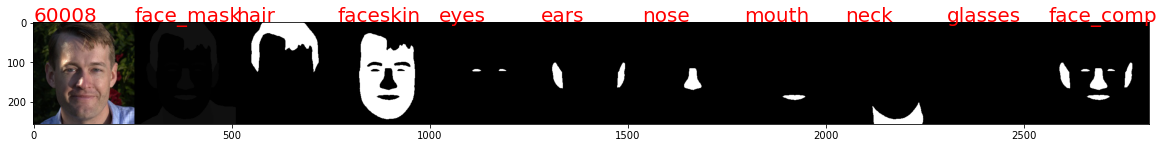

In [69]:
import numpy as np
import torch as th

# set_ = 'train'
set_ = 'valid'
path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
img_path = f'{path}/ffhq_256/{set_}'
segm_path = f'{path}/face_segment/{set_}/anno/'

# for i, p in enumerate(glob.glob(img_path + '/*.jpg')):
for i, p in enumerate([img_path + '/60174.jpg', img_path + '/60008.jpg']):
    img_name = p.split('/')[-1].split('.')[0]
    img = np.array(Image.open(p))
    segm = np.array(Image.open(segm_path + '/anno_' + img_name + '.png'))
    segm = np.repeat(segm[..., None], 3, axis=-1)
    print(segm.shape, img.shape)
    print(segm.min(), segm.max())
    
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(create_image_grid([img, 
                                  segm, 
                                  face_segment('faceseg_hair', segm)*255,
                                  face_segment('faceseg_faceskin', segm)*255,
                                  face_segment('faceseg_eyes', segm)*255,
                                  face_segment('faceseg_ears', segm)*255,
                                  face_segment('faceseg_nose', segm)*255,
                                  face_segment('faceseg_mouth', segm)*255,
                                  face_segment('faceseg_neck', segm)*255,
                                  face_segment('faceseg_glasses', segm)*255,
                                  face_segment('faceseg_eyes&ears&nose&mouth', segm)*255,
                                ], 
                                 text_labels=[img_name, 'face_mask', 'hair', 'faceskin', 'eyes', 'ears', 'nose', 'mouth', 'neck', 'glasses', 'face_comp'], n_rows=1))
    plt.show()
    if i == 10: break

# Extract eye balls (Using mediapipe)

In [70]:
!pip install -q mediapipe
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [71]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

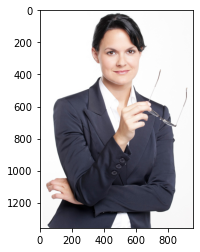

In [72]:

import cv2

img = cv2.imread("image.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [73]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
face_landmarks_proto.landmark.extend([
    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in detection_result.face_landmarks[0]
])

face_landmarks_proto_denom = list(solutions.drawing_utils._normalized_to_pixel_coordinates(landmark.x, landmark.y, image_height=img.shape[0], image_width=img.shape[1]) for landmark in detection_result.face_landmarks[0])
face_landmarks_proto_denom = np.array(face_landmarks_proto_denom)
print(face_landmarks_proto_denom.shape)

parts = {
    'l_eye': [468, 469, 470, 471, 472],
    'r_eye': [473, 474, 475, 476, 477],
    'l_pupil': [468],
    'r_pupil': [473],
    'l_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[468:469] - face_landmarks_proto_denom[469:472])**2, 1)), axis=0),
    'r_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[473:474] - face_landmarks_proto_denom[474:477])**2, 1)), axis=0),
}
print(parts)
for part in ['l_eye', 'r_eye']:
    for lm in face_landmarks_proto_denom[parts[part]]:
        cv2.circle(img, (int(lm[0]), int(lm[1])), 2, (0, 0, 255), -1)  #
cv2.circle(img, (int(face_landmarks_proto_denom[468][0]), int(face_landmarks_proto_denom[468][1])), int(parts['l_rad']), (0, 255, 0), -1)  #
cv2.circle(img, (int(face_landmarks_proto_denom[473][0]), int(face_landmarks_proto_denom[473][1])), int(parts['r_rad']), (0, 255, 0), -1)  #

fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
fig = plt.figure(figsize=(20, 20))
plt.imshow(annotated_image)
plt.show()

I0000 00:00:1718381991.818737  409380 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1718381991.852348  424912 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 470.199.02), renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
W0000 00:00:1718381991.852877  409380 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


(478, 2)
{'l_eye': [468, 469, 470, 471, 472], 'r_eye': [473, 474, 475, 476, 477], 'l_pupil': [468], 'r_pupil': [473], 'l_rad': 11.031745546102718, 'r_rad': 11.013864859597433}


# Run on FFHQ

[NormalizedLandmark(x=0.5181330442428589, y=0.7572284936904907, z=-0.04531164839863777, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5486325621604919, y=0.6642940640449524, z=-0.1297825127840042, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5292524099349976, y=0.6865692138671875, z=-0.058811869472265244, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5196690559387207, y=0.5713068246841431, z=-0.12046763300895691, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.551517128944397, y=0.6383646130561829, z=-0.14277242124080658, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.548125147819519, y=0.6006739139556885, z=-0.13885629177093506, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5329059958457947, y=0.5032569766044617, z=-0.08881610631942749, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3266289234161377, y=0.47678887844085693, z=-0.051898710429668427, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5276581645011902, y=0.4266973137

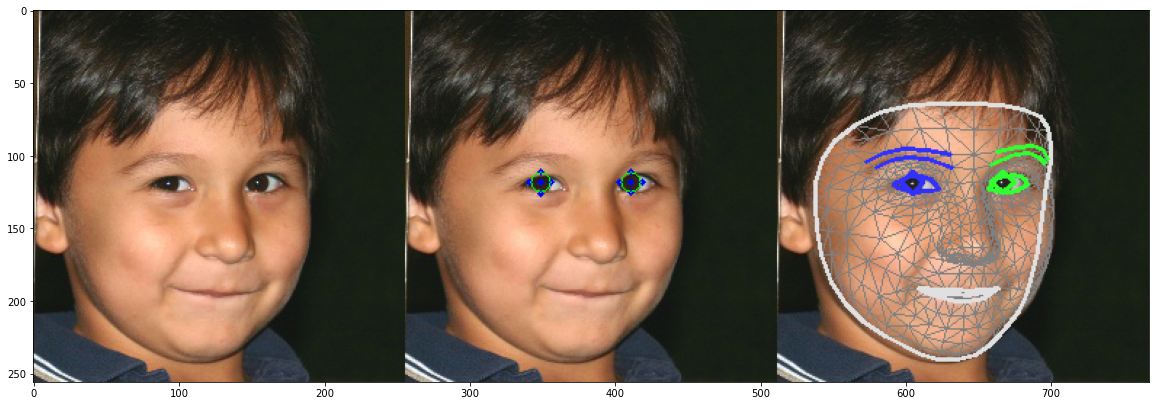

[NormalizedLandmark(x=0.49645712971687317, y=0.734381377696991, z=-0.02714988961815834, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49453848600387573, y=0.6696691513061523, z=-0.12606708705425262, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4953368902206421, y=0.6817138195037842, z=-0.051411982625722885, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.47332748770713806, y=0.5814560055732727, z=-0.12080521136522293, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4942205250263214, y=0.646834135055542, z=-0.1417260468006134, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49390774965286255, y=0.6111657619476318, z=-0.14275716245174408, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49404868483543396, y=0.5150512456893921, z=-0.10938059538602829, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.33274394273757935, y=0.4782940149307251, z=-0.013352476060390472, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49408483505249023, y=0.4514

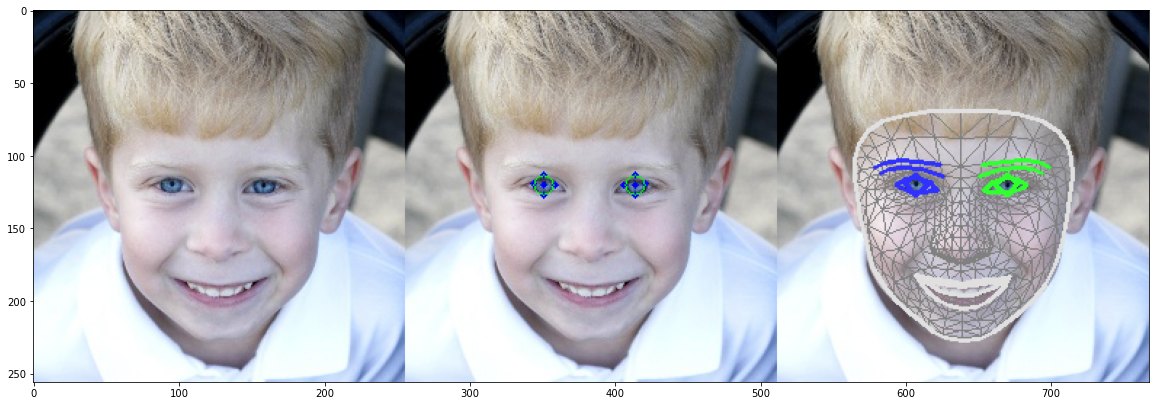

[NormalizedLandmark(x=0.5063202977180481, y=0.7153434753417969, z=-0.06643327325582504, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5239362716674805, y=0.6276924014091492, z=-0.13818050920963287, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5145475268363953, y=0.6518583297729492, z=-0.07114766538143158, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4996597170829773, y=0.5513386130332947, z=-0.11099240928888321, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5250660181045532, y=0.6038154363632202, z=-0.14763690531253815, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5233479738235474, y=0.5730169415473938, z=-0.13843950629234314, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5160125494003296, y=0.4981328547000885, z=-0.0746808648109436, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.339315265417099, y=0.4808276295661926, z=-0.0004874425067100674, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5120093822479248, y=0.4515550732

[NormalizedLandmark(x=0.5366599559783936, y=0.7413690686225891, z=-0.046921584755182266, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5781050324440002, y=0.6659802794456482, z=-0.13330534100532532, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.549022912979126, y=0.688201904296875, z=-0.06326385587453842, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5367275476455688, y=0.5727055072784424, z=-0.12294353544712067, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5802858471870422, y=0.6386224031448364, z=-0.14507555961608887, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5716376304626465, y=0.6002673506736755, z=-0.14097756147384644, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5411294102668762, y=0.502738356590271, z=-0.09206840395927429, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3220486640930176, y=0.4882866144180298, z=-0.055865056812763214, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5286090970039368, y=0.42518445849

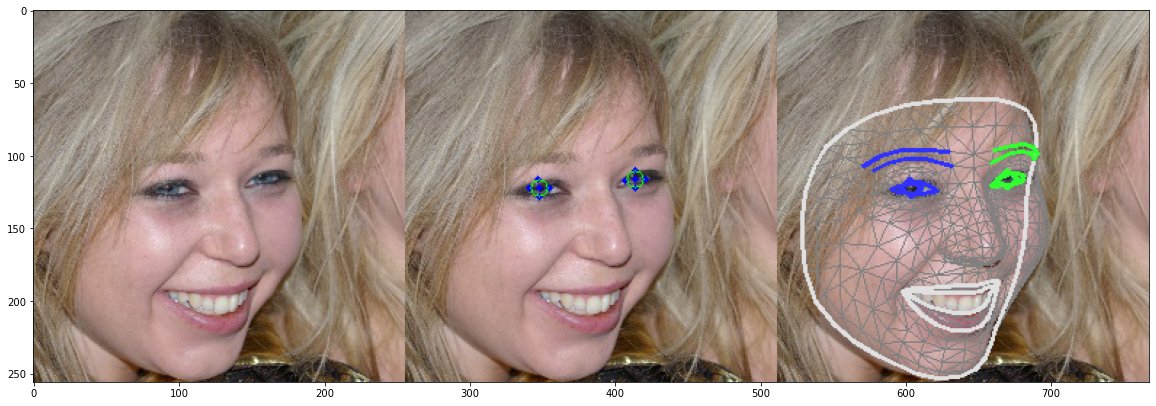

[NormalizedLandmark(x=0.4833192825317383, y=0.7124748229980469, z=-0.08646631985902786, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.481084406375885, y=0.6358806490898132, z=-0.15504413843154907, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4859737157821655, y=0.6603502631187439, z=-0.09004723280668259, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4614596664905548, y=0.551677942276001, z=-0.10869929939508438, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4802089333534241, y=0.6087812185287476, z=-0.16217723488807678, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4808385968208313, y=0.5749009847640991, z=-0.14895327389240265, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48519355058670044, y=0.49511444568634033, z=-0.06980983167886734, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3353467583656311, y=0.49203839898109436, z=0.06367523968219757, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48497259616851807, y=0.439202427

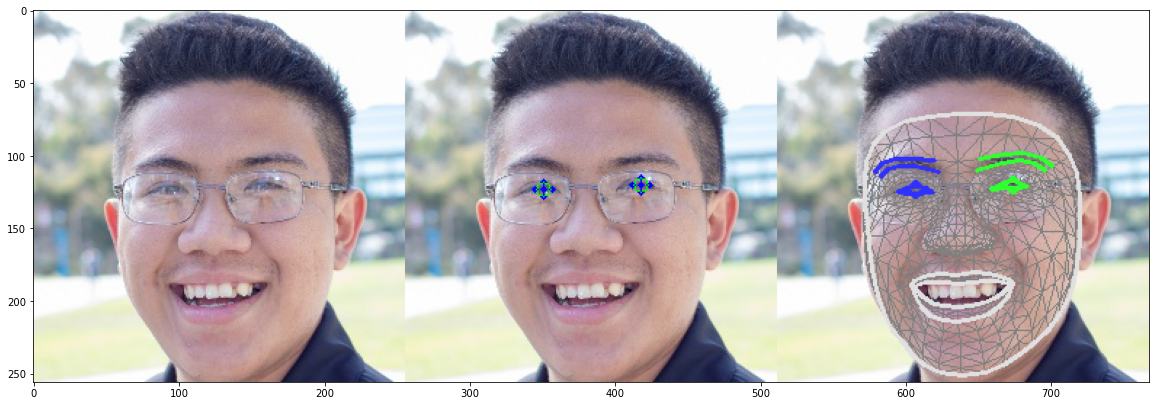

[NormalizedLandmark(x=0.5017518997192383, y=0.696133017539978, z=-0.07627563923597336, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5026466846466064, y=0.6217076778411865, z=-0.14655832946300507, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5020890235900879, y=0.6451536417007446, z=-0.08240347355604172, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4821127653121948, y=0.5465922355651855, z=-0.10849268734455109, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5023990273475647, y=0.5966364145278931, z=-0.15436537563800812, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.502156674861908, y=0.5669537782669067, z=-0.1429801732301712, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5020144581794739, y=0.49554431438446045, z=-0.06985621899366379, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3354586064815521, y=0.48019498586654663, z=0.03540128096938133, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5013179183006287, y=0.430514067411

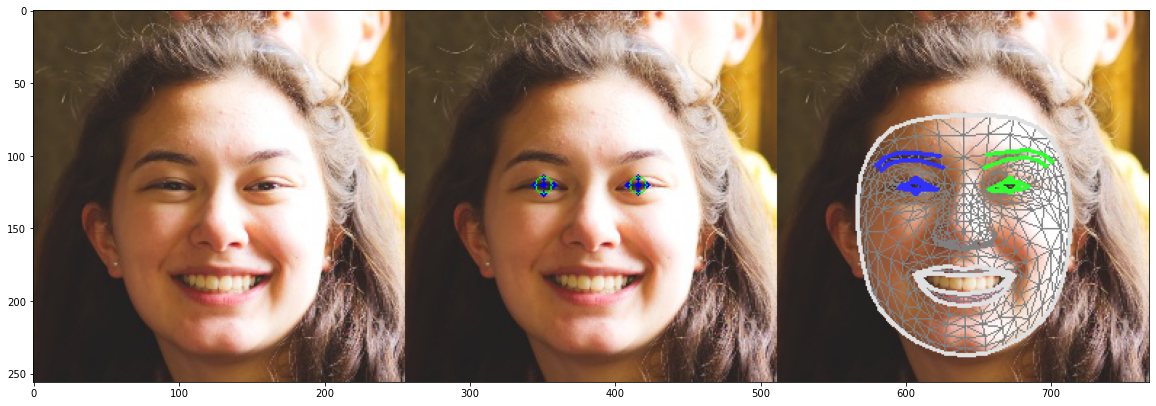

[NormalizedLandmark(x=0.4916519522666931, y=0.6876159310340881, z=-0.06117268651723862, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48407962918281555, y=0.6250362396240234, z=-0.13836035132408142, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4879067540168762, y=0.6443378329277039, z=-0.07149343937635422, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4669148921966553, y=0.5467827320098877, z=-0.10868964344263077, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4839821755886078, y=0.6014169454574585, z=-0.14819015562534332, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48527729511260986, y=0.5698280334472656, z=-0.14077995717525482, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49002861976623535, y=0.4936777353286743, z=-0.08161211013793945, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.33960723876953125, y=0.4746984839439392, z=0.033223532140254974, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49182844161987305, y=0.44323

[NormalizedLandmark(x=0.5312095284461975, y=0.7126076817512512, z=-0.03873704373836517, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5213413238525391, y=0.6446088552474976, z=-0.12792643904685974, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5176388025283813, y=0.6588644981384277, z=-0.05644381046295166, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4959172010421753, y=0.5606194734573364, z=-0.11679039150476456, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5213944315910339, y=0.6218862533569336, z=-0.14145715534687042, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5197533965110779, y=0.5878466963768005, z=-0.1390363574028015, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5148177742958069, y=0.5017088651657104, z=-0.09640064835548401, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3345486521720886, y=0.472381591796875, z=-0.017231469973921776, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5125914812088013, y=0.45575416088

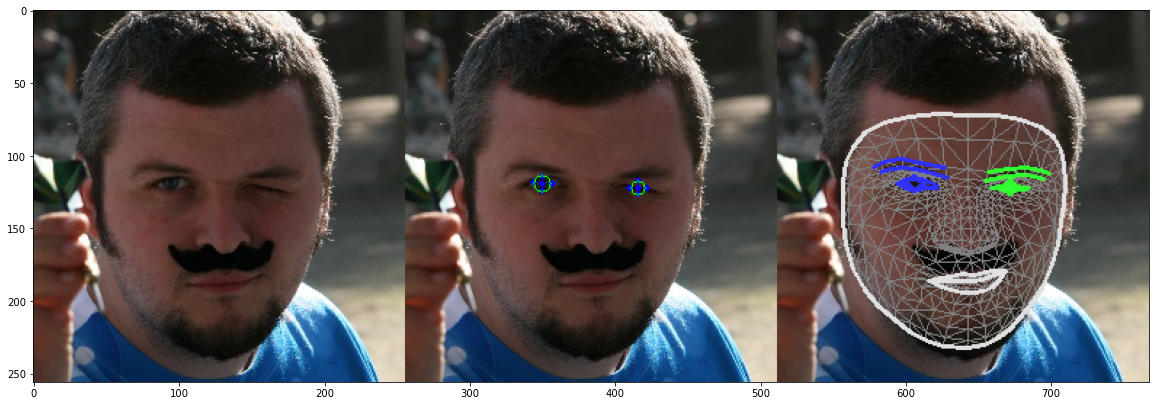

[NormalizedLandmark(x=0.5222685933113098, y=0.7151229977607727, z=-0.06037795543670654, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5335268974304199, y=0.636759340763092, z=-0.1309095025062561, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5241199731826782, y=0.657929003238678, z=-0.06666498631238937, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5056138038635254, y=0.550969660282135, z=-0.10763654112815857, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5343250036239624, y=0.6110199689865112, z=-0.14015372097492218, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5311166048049927, y=0.576386570930481, z=-0.13211609423160553, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5192685723304749, y=0.49177733063697815, z=-0.07321035116910934, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3352527916431427, y=0.4727698564529419, z=-0.011003203690052032, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5152009129524231, y=0.4287450015544

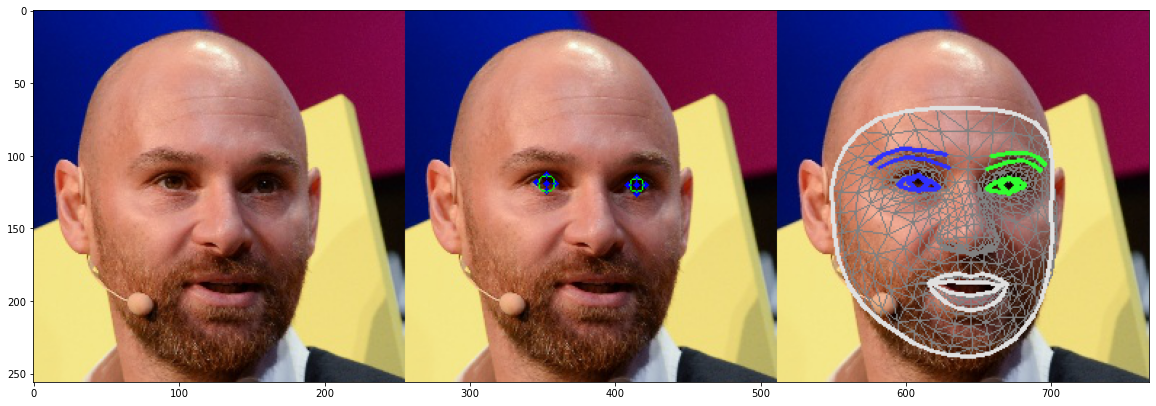

[NormalizedLandmark(x=0.4852345883846283, y=0.7580352425575256, z=-0.042629823088645935, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.45621731877326965, y=0.6776984930038452, z=-0.12882892787456512, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4716101884841919, y=0.6954723596572876, z=-0.060146525502204895, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.44390690326690674, y=0.5745829343795776, z=-0.10639970749616623, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.45415717363357544, y=0.6490890979766846, z=-0.14150752127170563, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4573480188846588, y=0.6075783967971802, z=-0.13762544095516205, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4718628525733948, y=0.5037445425987244, z=-0.08916838467121124, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.33765900135040283, y=0.47587934136390686, z=0.044292133301496506, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4755752384662628, y=0.436

[NormalizedLandmark(x=0.4897522032260895, y=0.71694415807724, z=-0.062406908720731735, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4834647476673126, y=0.6400340795516968, z=-0.14490839838981628, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4872351884841919, y=0.6613709926605225, z=-0.07560031116008759, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.46780258417129517, y=0.5567720532417297, z=-0.11554387956857681, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.483399361371994, y=0.6146866083145142, z=-0.15541359782218933, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48517248034477234, y=0.5814585089683533, z=-0.147940993309021, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4921540915966034, y=0.4994635581970215, z=-0.08597590029239655, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.33468490839004517, y=0.4755992591381073, z=0.02667454443871975, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4949102997779846, y=0.434261828660

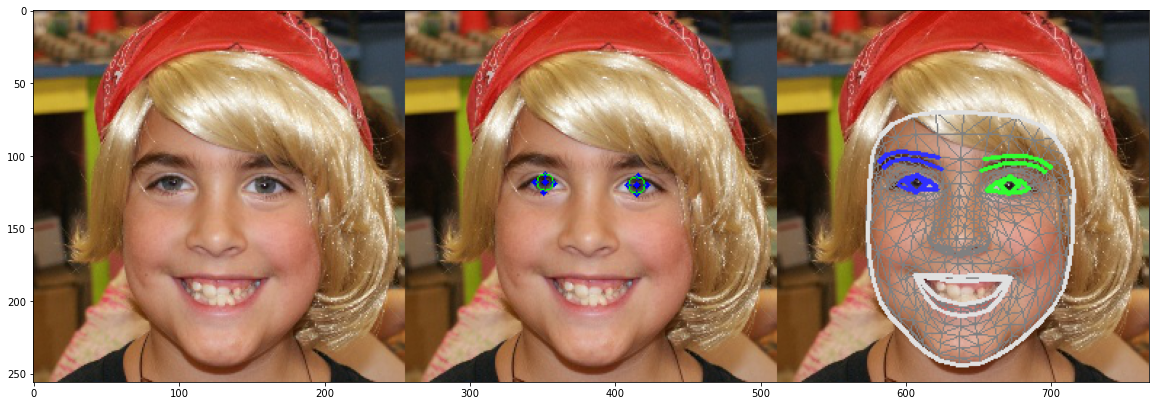

In [87]:

def find_eyes(img, vis=False):

    image_mp = mp.Image.create_from_file(img)
    image = np.array(Image.open(img))
    H, W, _ = image.shape

    detection_result = detector.detect(image_mp)
    print(detection_result.face_landmarks[0])
    print(len(detection_result.face_landmarks[0]))
    # face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    # face_landmarks_proto.landmark.extend([
    #     landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in detection_result.face_landmarks[0]
    # ])

    face_landmarks_proto_denom = list(solutions.drawing_utils._normalized_to_pixel_coordinates(landmark.x, landmark.y, image_height=H, image_width=W) for landmark in detection_result.face_landmarks[0])
    face_landmarks_proto_denom = np.array(face_landmarks_proto_denom)
    print(face_landmarks_proto_denom.shape)

    parts = {
        'l_eye': [468, 469, 470, 471, 472],
        'r_eye': [473, 474, 475, 476, 477],
        'l_pupil': [468],
        'r_pupil': [473],
        'l_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[468:469] - face_landmarks_proto_denom[469:472])**2, 1)), axis=0),
        'r_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[473:474] - face_landmarks_proto_denom[474:477])**2, 1)), axis=0),
    }
    if vis:
        image_vis = image.copy()
        for part in ['l_eye', 'r_eye']:
            for lm in face_landmarks_proto_denom[parts[part]]:
                cv2.circle(image_vis, (int(lm[0]), int(lm[1])), 2, (0, 0, 255), -1)  #
        cv2.circle(image_vis, (int(face_landmarks_proto_denom[468][0]), int(face_landmarks_proto_denom[468][1])), int(parts['l_rad']), (0, 255, 0), 1)  #
        cv2.circle(image_vis, (int(face_landmarks_proto_denom[473][0]), int(face_landmarks_proto_denom[473][1])), int(parts['r_rad']), (0, 255, 0), 1)  #

        annotated_image = draw_landmarks_on_image(image_mp.numpy_view(), detection_result)

        fig = plt.figure(figsize=(20, 20))
        plt.imshow(create_image_grid([
            image,
            image_vis,
            annotated_image
        ]))
        plt.show()

path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'
img_path = f'{path}/ffhq_256/{set_}/'
for idx, img in enumerate(glob.glob(img_path + '/*.jpg')):
    find_eyes(img, vis=True)
    if idx == 10: break